In [1]:
import cv2
import numpy as np
from random import shuffle

IMG_SIZE = 224
LR = 1e-4

In [2]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == 'covid': return 1
    elif word_label == 'noncovid': return 0

In [3]:
def createDataSplitSet(datapath):
    X=[]
    y=[]

    for img in os.listdir(datapath):
        label = label_img(img)
        path = os.path.join(datapath, img)
        #image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
        image = cv2.resize(cv2.imread(path), (IMG_SIZE, IMG_SIZE))
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #image = np.resize(image, (224,224,1))

        X.append(np.array(image))
        y.append(label)

    return np.array(X), np.array(y)

In [4]:
train_dir = '/Users/sardarsaqib/Documents/University of Essex/DSSM/Resit Assignment/Accuracy Improvement/Final Try/covid19_CT/train'
validation_dir = '/Users/sardarsaqib/Documents/University of Essex/DSSM/Resit Assignment/Accuracy Improvement/Final Try/covid19_CT/validation'
test_dir = '/Users/sardarsaqib/Documents/University of Essex/DSSM/Resit Assignment/Accuracy Improvement/Final Try/covid19_CT/test'

In [5]:
import os
train_X, train_y = createDataSplitSet(train_dir)
val_X, val_y = createDataSplitSet(validation_dir)
test_X, test_y = createDataSplitSet(test_dir)

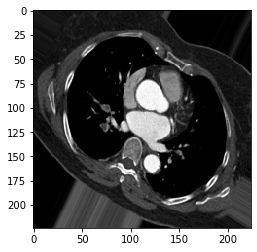

In [6]:
from matplotlib import pyplot as plt
plt.imshow(train_X[2849], interpolation='nearest')
plt.show()

In [7]:
train_y

array([1, 1, 1, ..., 0, 0, 0])

In [25]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras import Model

img_input = Input(shape=(IMG_SIZE, IMG_SIZE))

In [26]:
base_model = DenseNet201(weights='imagenet', include_top=True, input_shape=(224,224,3), pooling=None)
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [27]:
for layer in base_model.layers: 
  layer.trainable = False
  print('Layer ' + layer.name + ' frozen.')

Layer input_5 frozen.
Layer zero_padding2d_4 frozen.
Layer conv1/conv frozen.
Layer conv1/bn frozen.
Layer conv1/relu frozen.
Layer zero_padding2d_5 frozen.
Layer pool1 frozen.
Layer conv2_block1_0_bn frozen.
Layer conv2_block1_0_relu frozen.
Layer conv2_block1_1_conv frozen.
Layer conv2_block1_1_bn frozen.
Layer conv2_block1_1_relu frozen.
Layer conv2_block1_2_conv frozen.
Layer conv2_block1_concat frozen.
Layer conv2_block2_0_bn frozen.
Layer conv2_block2_0_relu frozen.
Layer conv2_block2_1_conv frozen.
Layer conv2_block2_1_bn frozen.
Layer conv2_block2_1_relu frozen.
Layer conv2_block2_2_conv frozen.
Layer conv2_block2_concat frozen.
Layer conv2_block3_0_bn frozen.
Layer conv2_block3_0_relu frozen.
Layer conv2_block3_1_conv frozen.
Layer conv2_block3_1_bn frozen.
Layer conv2_block3_1_relu frozen.
Layer conv2_block3_2_conv frozen.
Layer conv2_block3_concat frozen.
Layer conv2_block4_0_bn frozen.
Layer conv2_block4_0_relu frozen.
Layer conv2_block4_1_conv frozen.
Layer conv2_block4_1_

In [28]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 1920) dtype=float32 (created by layer 'avg_pool')>

In [29]:
#adding three dense layers
last = base_model.layers[-2].output
x = Dense(128, activation='relu', name='fc1')(last)
x = Dense(64, activation='relu', name='fc2')(x)
x = Dense(1, activation='sigmoid', name='output_final_layer')(x)
model = Model(base_model.input, x)

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [31]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [32]:
history = model.fit(train_X, train_y,
                              batch_size=10,
                              epochs=25, 
                              validation_data=(val_X, val_y))

Epoch 1/25
285/285 [==============================] - 638s 2s/step - loss: 0.6001 - acc: 0.6728 - val_loss: 0.4028 - val_acc: 0.8158
Epoch 2/25
285/285 [==============================] - 605s 2s/step - loss: 0.3681 - acc: 0.8284 - val_loss: 0.3260 - val_acc: 0.8605
Epoch 3/25
285/285 [==============================] - 581s 2s/step - loss: 0.3099 - acc: 0.8637 - val_loss: 0.3453 - val_acc: 0.8395
Epoch 4/25
285/285 [==============================] - 564s 2s/step - loss: 0.2817 - acc: 0.8742 - val_loss: 0.3120 - val_acc: 0.8658
Epoch 5/25
285/285 [==============================] - 568s 2s/step - loss: 0.2553 - acc: 0.8883 - val_loss: 0.4006 - val_acc: 0.8158
Epoch 6/25
285/285 [==============================] - 567s 2s/step - loss: 0.2000 - acc: 0.9119 - val_loss: 0.2540 - val_acc: 0.8789
Epoch 7/25
285/285 [==============================] - 568s 2s/step - loss: 0.1575 - acc: 0.9354 - val_loss: 0.2564 - val_acc: 0.8816
Epoch 8/25
285/285 [==============================] - 570s 2s/step - 

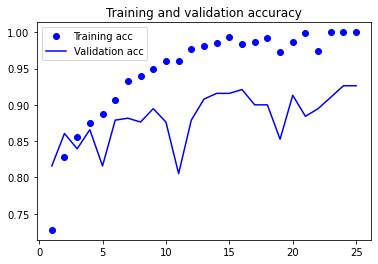

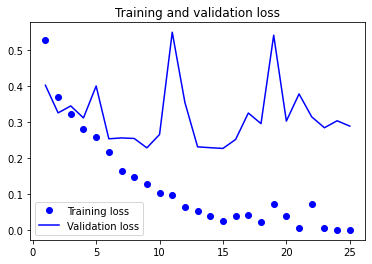

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
from sklearn.metrics import accuracy_score

## Test Accuracy
predictions = model.predict(test_X)
ypred = predictions > 0.5
test_acc = accuracy_score(test_y, ypred)

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1score, _ = precision_recall_fscore_support(test_y, ypred, average='binary')

auc = roc_auc_score(test_y, ypred)

print("Train Accuracy:\t", acc[-1])
print("Val Accuracy:\t", val_acc[-1])
print("Test Accuracy:\t", test_acc)
print("Precision:\t", precision)
print("Recall:\t\t", recall)
print("F1 Score:\t", f1score)
print("AUC:\t\t", auc)

Train Accuracy:	 1.0
Val Accuracy:	 0.9263157844543457
Test Accuracy:	 0.9035087719298246
Precision:	 0.9078014184397163
Recall:		 0.8982456140350877
F1 Score:	 0.9029982363315696
AUC:		 0.9035087719298246
